# Exercises

Answer the questions below by using a combination of the techniques discussed in the lesson that you think are appropriate.

- How many different cases are there by department?

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    expr,
    col,
    to_timestamp,
    format_string,
    regexp_extract,
    datediff,
    current_timestamp,
    when,
    max,
    lit
)

import wrangle

In [2]:
case_df = wrangle.wrangle_311()

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments


In [3]:
case_df

DataFrame[dept_division: string, case_id: int, case_opened_date: timestamp, case_closed_date: timestamp, case_due_date: timestamp, case_late: boolean, num_days_late: double, case_closed: boolean, service_request_type: string, SLA_days: double, case_status: string, source_id: string, request_address: string, council_district: string, num_weeks_late: double, zipcode: string, case_age: int, days_to_closed: int, case_lifetime: int, department: string, dept_subject_to_SLA: boolean]

In [5]:
print('\n df shape: (%d, %d)\n' % (case_df.count(), len(case_df.columns)))



 df shape: (841704, 21)



In [8]:
case_df.groupBy('department').count().show()

+--------------------+------+
|          department| count|
+--------------------+------+
|         Solid Waste|279270|
|Animal Care Services|116915|
|Trans & Cap Impro...| 96193|
|  Parks & Recreation| 19907|
|    Customer Service|  2849|
|        Metro Health|  5163|
|        City Council|    33|
|DSD/Code Enforcement|321374|
+--------------------+------+



In [10]:
case_pd = case_df.groupBy('department').count().toPandas()

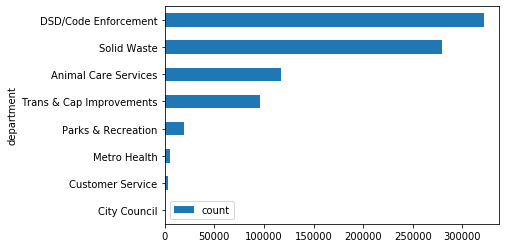

In [16]:
case_pd.set_index('department').sort_values(by = ['count']).plot.barh()

- Does the percentage of cases that are late vary by department?

In [17]:
case_df.show(1, vertical=True)

-RECORD 0------------------------------------
 dept_division        | Field Operations     
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true      

In [20]:
case_df.filter(expr('case_late == "true"')).groupBy('department').count().show()

+--------------------+-----+
|          department|count|
+--------------------+-----+
|         Solid Waste|32945|
|Animal Care Services|23276|
|Trans & Cap Impro...| 5411|
|  Parks & Recreation| 3797|
|    Customer Service| 2010|
|        Metro Health|  829|
|DSD/Code Enforcement|26235|
+--------------------+-----+



In [41]:
case_status = case_df.groupBy('department').pivot('case_late').count().na.fill(0)

In [42]:
case_status.show()

+--------------------+------+-----+
|          department| false| true|
+--------------------+------+-----+
|         Solid Waste|246325|32945|
|Animal Care Services| 93639|23276|
|Trans & Cap Impro...| 90782| 5411|
|    Customer Service|   839| 2010|
|  Parks & Recreation| 16110| 3797|
|        Metro Health|  4334|  829|
|        City Council|    33|    0|
|DSD/Code Enforcement|295139|26235|
+--------------------+------+-----+



In [43]:
from pyspark.sql.functions import sum

In [52]:
cases_late = (case_status
 .select('department', 
         ((case_status.true/(case_status.false + case_status.true))*100)
         .alias('percent_cases_late')))

In [53]:
cases_late.show()

+--------------------+------------------+
|          department|percent_cases_late|
+--------------------+------------------+
|         Solid Waste| 11.79682744297633|
|Animal Care Services|19.908480520035923|
|Trans & Cap Impro...|5.6251494391483785|
|    Customer Service| 70.55107055107055|
|  Parks & Recreation|19.073692670919776|
|        Metro Health|16.056556265736972|
|        City Council|               0.0|
|DSD/Code Enforcement|  8.16338596152769|
+--------------------+------------------+



In [54]:
cases_late.toPandas()

,department,percent_cases_late
0,Solid Waste,11.796827
1,Animal Care Services,19.908481
2,Trans & Cap Improvements,5.625149
3,Customer Service,70.551071
4,Parks & Recreation,19.073693
5,Metro Health,16.056556
6,City Council,0.000000
7,DSD/Code Enforcement,8.163386


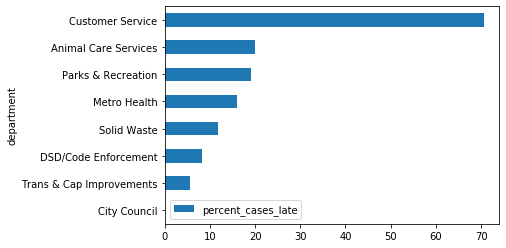

In [60]:
cases_late.toPandas().set_index('department').sort_values(by = ['percent_cases_late']).plot.barh()

- On average, how late are the late cases by department?

In [64]:
from pyspark.sql.functions import avg

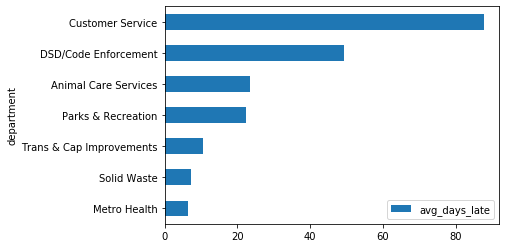

In [76]:
case_df.filter(case_df.case_late == 'true').groupBy('department').agg(avg('num_days_late').alias('avg_days_late')).toPandas().set_index('department').sort_values(by = ['avg_days_late']).plot.barh()




- What is the service type that is the most late? Just for Parks and Rec?

In [81]:
from pyspark.sql.functions import asc, desc

In [90]:
case_df.groupBy('department', 'service_request_type').agg(avg('num_days_late')).sort(desc('avg(num_days_late)')).show()

+--------------------+--------------------+------------------+
|          department|service_request_type|avg(num_days_late)|
+--------------------+--------------------+------------------+
|DSD/Code Enforcement|  Zoning: Junk Yards| 175.9563621042095|
|DSD/Code Enforcement|Labeling for Used...|162.43032902285717|
|DSD/Code Enforcement|Record Keeping of...|153.99724039428568|
|DSD/Code Enforcement|Signage Requied f...|151.63868055333333|
|DSD/Code Enforcement|Storage of Used M...|     142.112556415|
|DSD/Code Enforcement|Zoning: Recycle Yard|135.92851612479797|
|DSD/Code Enforcement|Donation Containe...|131.75610506358706|
|DSD/Code Enforcement|License Requied U...|128.79828704142858|
|Trans & Cap Impro...|Traffic Signal Gr...| 77.90021217000002|
|    Customer Service|           Complaint| 72.51790932659713|
|DSD/Code Enforcement|             Vendors| 66.11831254322686|
|  Parks & Recreation|Reservation Assis...|       66.03116319|
|DSD/Code Enforcement|         Curbstoning|60.604338577

In [91]:
case_df.groupBy('department', 'service_request_type').agg(max('num_days_late')).sort(desc('max(num_days_late)')).show()

+--------------------+--------------------+------------------+
|          department|service_request_type|max(num_days_late)|
+--------------------+--------------------+------------------+
|DSD/Code Enforcement|        Bandit Signs|       519.6980787|
|DSD/Code Enforcement|   No Address Posted|       514.9381944|
|DSD/Code Enforcement|    Permits Building|       506.1483218|
|DSD/Code Enforcement|  Zoning: Junk Yards|        494.949838|
|DSD/Code Enforcement|Zoning: Recycle Yard|494.94844910000006|
|DSD/Code Enforcement|         Curbstoning|493.10947919999995|
|DSD/Code Enforcement|             Vendors|492.16497689999994|
|Animal Care Services|Public Nuisance(O...|        452.098287|
|  Parks & Recreation|            Painting|       427.6660069|
|  Parks & Recreation| Sportfield Lighting|       417.9064468|
|  Parks & Recreation|             Masonry|       410.7945718|
|DSD/Code Enforcement|Overgrown Yard/Trash|410.28771989999996|
|Animal Care Services|Animal Permits Re...|410.18685189